# Property features contributing to Prices

## Business Question and Approach

Questions to answer:
    
    1.)What are the factors that go into Seattle's Airbnb prices?
    
    2.)Can a reasonable pricing model be made?
    
    3.)How can one maximize the price?
    
    4.)How does customer review counts/score correlate with pricing?

Todo:

    -find features
    
    -build reasonable which would prove both 1.) and 2.)
    
    -use visuals to find possible maximum price 3.) for locations in Seattle on platform 
    
    -use visual to find insight for 4.)

## Ingestion and Cleaning of Data

**importing packages and ingesting dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR as svr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.tree import DecisionTreeRegressor as dtr
from xgboost.sklearn import XGBRegressor as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('listings.csv')
dcal = pd.read_csv('calendar.csv')
drev = pd.read_csv('reviews.csv')

**inspecting all numeric columns in dataframe**

In [3]:
df.describe().columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [4]:
drev.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [5]:
drev['id'].unique

<bound method Series.unique of 0        38917982
1        39087409
2        39820030
3        40813543
4        41986501
           ...   
84844    50436321
84845    51024875
84846    51511988
84847    52814482
84848    56429621
Name: id, Length: 84849, dtype: int64>

**merge data**

In [6]:
dfgx=pd.merge(drev[['id','listing_id']],df,on='id',how='inner')
#dfg=pd.merge(d[['','listing_id']],df,on='id',how='inner')

In [7]:
dfg=pd.merge(dcal[['date','listing_id']],dfgx,on='listing_id',how='inner')

**adding target "price" as numeric column**

In [8]:
dfg['price'] = dfg['price'].str.replace('$','')
dfg['price'] = dfg['price'].str.replace(',','')
dfg['price'] = dfg['price'].astype(float)

**to see if pricing is cyclical hence adding month as numeric**

In [9]:
dfg['month'] = pd.DatetimeIndex(dfg['date']).month

**gathering all numeric columns**

In [10]:
num_cols= dfg.describe().columns

**dataframe with dropped columns with na values**

In [11]:
df1 = dfg[num_cols].dropna(axis=1)
df1.shape

(3285, 23)

**also dropping id columns**

In [12]:
df1 =df1.drop(['id', 'scrape_id', 'host_id','listing_id'],axis=1)
df1.shape

(3285, 19)

## Data Exploration

**columns for inspection**

In [13]:
df1.columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'calculated_host_listings_count', 'month'],
      dtype='object')

**make correlations and heatmap as visiualisation**

In [14]:
cor=df1.corr()

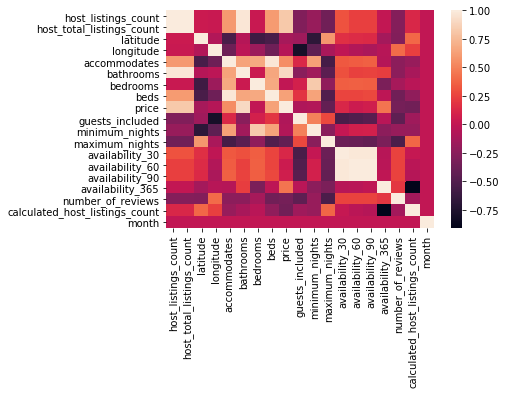

In [15]:
sb.heatmap(cor)

**heatmap inspection**

we find that as regard to price the features with correlations outside of interval [-0.2,0.2] and therefore relevant to the analysis are: 'bedrooms', 'accommodates','guests_included','latitude','host_listings_count', 'host_total_listings_count','bathrooms',and 'beds'

In case our model needs more relevant feature the rest will be used for feature engineering

**Inspection and Feature Engineering of none relevant Features**

In [16]:
dfx=dfg[['minimum_nights','maximum_nights','availability_365','number_of_reviews','month','price']]


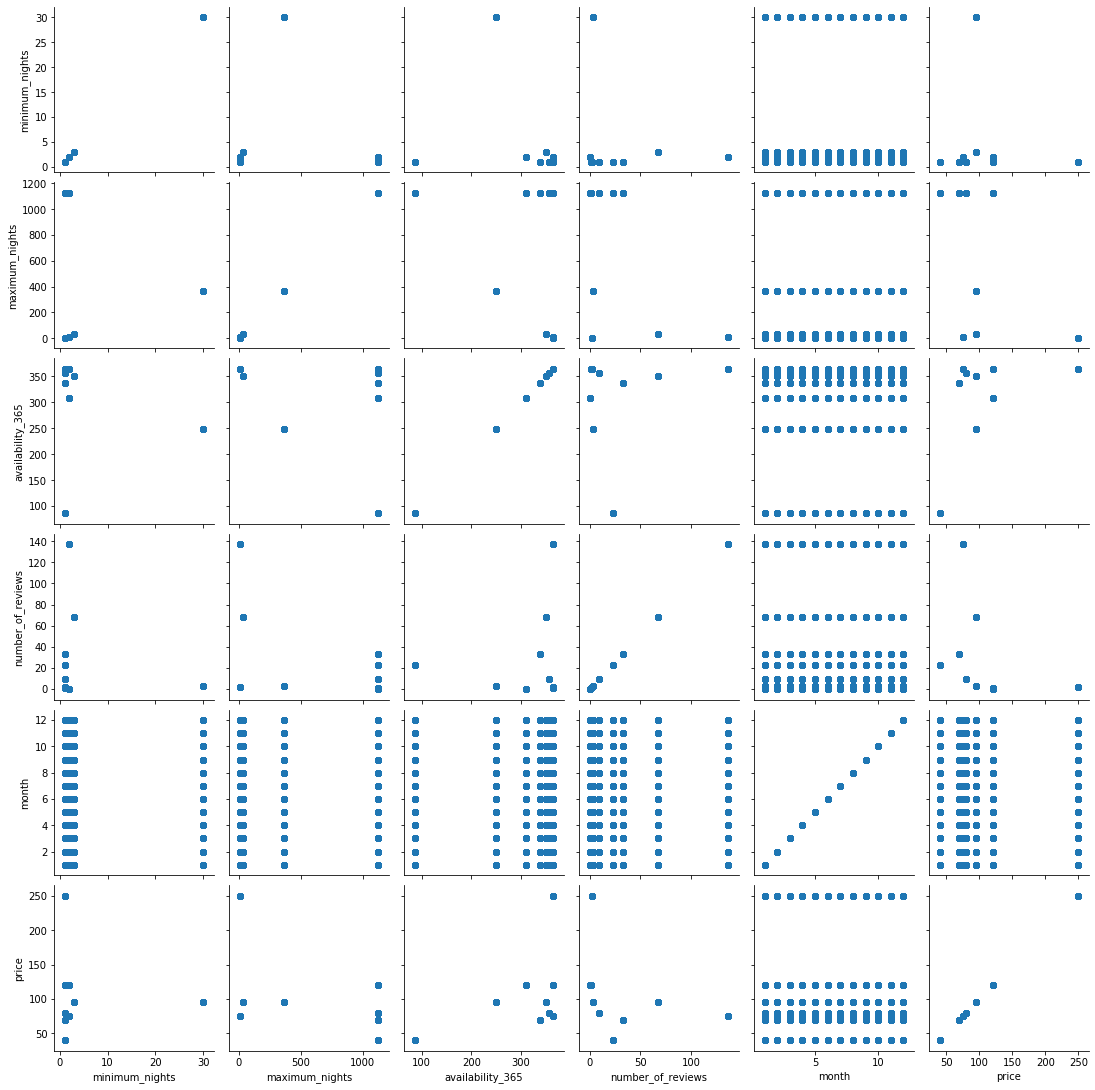

In [17]:
g=sb.PairGrid(dfx)
g.map(plt.scatter)

attempted feature engineering weaker features

C:\Users\aimaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


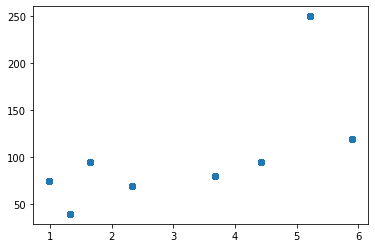

In [18]:
plt.scatter((np.log(dfx['availability_365'].values/dfx['number_of_reviews'].values)),dfx['price'].values)

In [19]:
d=np.log(dfx['availability_365'].values/dfx['number_of_reviews'].values)
dx=pd.DataFrame(d,columns=['av365/numrev']).join(dfx['price'])

C:\Users\aimaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


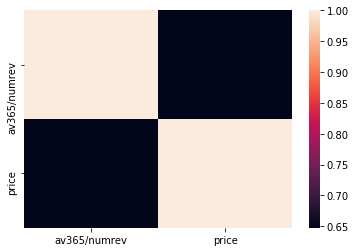

In [20]:
corx=dx.corr()
sb.heatmap(corx)

**success, a good feature if need be!**

In [21]:
df1.columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'calculated_host_listings_count', 'month'],
      dtype='object')

In [22]:
df1=df1.drop(['minimum_nights','maximum_nights','availability_365','number_of_reviews'],axis=1)


**the columns that go into analysis also noting again that "price" is the target**

In [23]:
df1.columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'availability_30', 'availability_60',
       'availability_90', 'calculated_host_listings_count', 'month'],
      dtype='object')

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3285 entries, 0 to 3284
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_listings_count             3285 non-null   float64
 1   host_total_listings_count       3285 non-null   float64
 2   latitude                        3285 non-null   float64
 3   longitude                       3285 non-null   float64
 4   accommodates                    3285 non-null   int64  
 5   bathrooms                       3285 non-null   float64
 6   bedrooms                        3285 non-null   float64
 7   beds                            3285 non-null   float64
 8   price                           3285 non-null   float64
 9   guests_included                 3285 non-null   int64  
 10  availability_30                 3285 non-null   int64  
 11  availability_60                 3285 non-null   int64  
 12  availability_90                 32

**split data for model validation with "price" as target**

splitting data of feature with correlations outside of [-0.2,0.2] interval on the heatmap

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df1[['bedrooms', 'accommodates','guests_included','latitude','host_listings_count', 'host_total_listings_count','bathrooms','beds']], df1['price'], test_size=0.20, random_state=42,shuffle=True)

In [26]:
X_test.head()

,bedrooms,accommodates,guests_included,latitude,host_listings_count,host_total_listings_count,bathrooms,beds
2209,1.0,1,1,47.664047,1.0,1.0,1.0,1.0
2770,0.0,2,2,47.678761,1.0,1.0,1.0,1.0
1656,1.0,2,1,47.603388,2.0,2.0,1.0,1.0
1652,1.0,2,1,47.603388,2.0,2.0,1.0,1.0
1451,1.0,6,1,47.613135,84.0,84.0,2.0,3.0


## Analysis

### Data Modelling

**Build Model Pipeline**

**Impute** -missing values with the mean because this best practice used in case there is missing data.

**Scale** -the values because as we can see some columns may carry more weight, it may also take care of the ordinal categoricals and scaling generally give better results.

**Linear Regression algorithm** -as it is generally first choice for regression analysis and it is a regression as "price our target is a continuous variable, and this would also facilitate maximization.

In [27]:
pipe = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.NaN,strategy='mean')),
                       ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
                       ("Linrs", LinearRegression())])

pipe.fit(X_train.values , y_train.values)
pred = pipe.predict(X_test.values)

### Results

**Evaluation of Model** 

to see if it is reasonable and to validate the features which would contribute to 
a Airbnb location in Seattle

**mean squared error** -to access deviation of predicted values to actual on a dollar scale

**r squared score** -to access how well predicted and actual values correlate 

In [28]:
print(mean_squared_error(y_test,pred),r2_score(y_test,pred))

0.5286844847770736 0.9998248320469456


**this is a great model making on average close to $0.50 errors and gives us a wonderful correlation. this also *validates* the *features* we used for *pricing*.**

that is question **1.)** and **2.)** **answered**

**Visualising Results**

make visualisations to help us decide how to maximize price Question **3.)**

Text(0.5, 1.0, 'price vs beds')

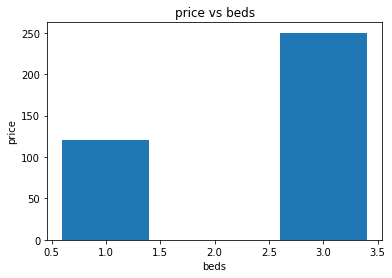

In [29]:
plt.bar(df1.beds.astype(int),df1.price)
plt.xlabel('beds')
plt.ylabel('price')
plt.title('price vs beds')

Text(0.5, 1.0, 'price vs beds')

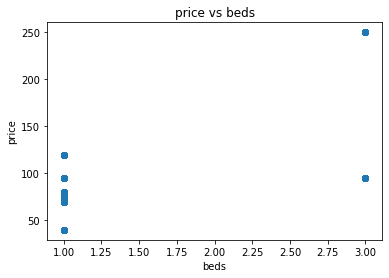

In [30]:
plt.scatter(df1.beds.astype(int),df1.price)
plt.xlabel('beds')
plt.ylabel('price')
plt.title('price vs beds')

Text(0.5, 1.0, 'price vs bathrooms')

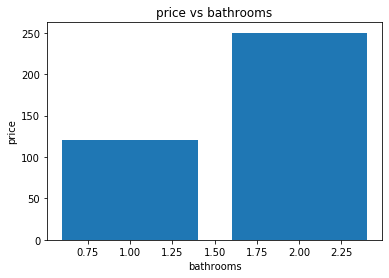

In [31]:
plt.bar(df1.bathrooms.astype(int),df1.price)
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.title('price vs bathrooms')

Text(0.5, 1.0, 'price vs bathrooms')

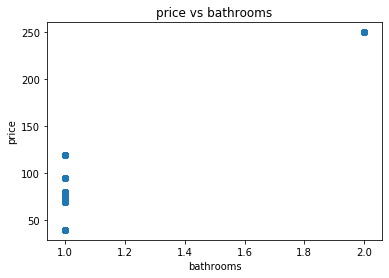

In [32]:
plt.scatter(df1.bathrooms.astype(int),df1.price)
plt.xlabel('bathrooms')
plt.ylabel('price')
plt.title('price vs bathrooms')

Text(0.5, 1.0, 'price vs bedrooms')

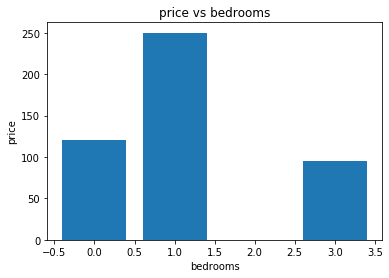

In [33]:
plt.bar(df1.bedrooms,df1.price)
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.title('price vs bedrooms')

Text(0.5, 1.0, 'price vs host_listings_count')

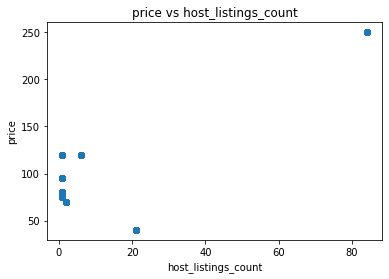

In [34]:
plt.scatter(df1.host_listings_count,df1.price)
plt.xlabel('host_listings_count')
plt.ylabel('price')
plt.title('price vs host_listings_count')

Text(0.5, 1.0, 'hist of host_total_listings_count')

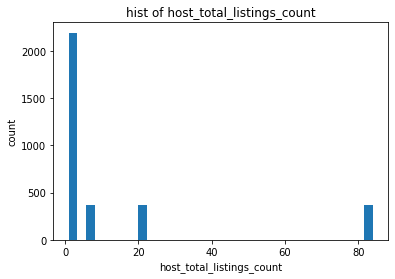

In [35]:
plt.hist(df1.host_listings_count,bins=35)
plt.xlabel('host_total_listings_count')
plt.ylabel('count')
plt.title('hist of host_total_listings_count')

Text(0.5, 1.0, 'price vs host_total_listings_count')

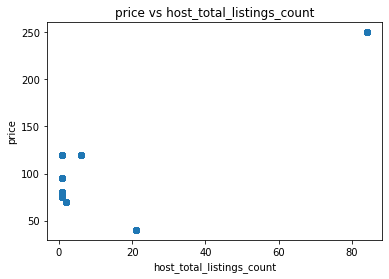

In [36]:
plt.scatter(df1.host_total_listings_count,df1.price)
plt.xlabel('host_total_listings_count')
plt.ylabel('price')
plt.title('price vs host_total_listings_count')

Text(0.5, 1.0, 'price vs latitude')

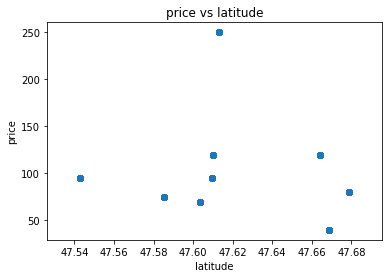

In [37]:
plt.scatter(df1.latitude,df1.price)
plt.xlabel('latitude')
plt.ylabel('price')
plt.title('price vs latitude')

Text(0.5, 1.0, 'price vs accommodates')

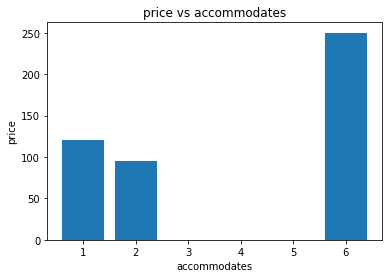

In [38]:
plt.bar(df1.accommodates,df1.price)
plt.xlabel('accommodates')
plt.ylabel('price')
plt.title('price vs accommodates')

Text(0.5, 1.0, 'price vs guests_included')

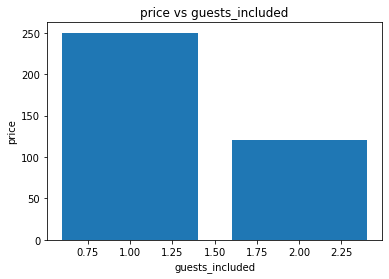

In [39]:
plt.bar(df1.guests_included,df1.price)
plt.xlabel('guests_included')
plt.ylabel('price')
plt.title('price vs guests_included')

**this is the array of values for each feature that could maximize price**

In [40]:
pd.DataFrame([[2,6,1,47.61,80,80,3,3]],columns=['bedrooms', 'accommodates','guests_included','latitude','host_listings_count', 'host_total_listings_count','bathrooms','beds'])

,bedrooms,accommodates,guests_included,latitude,host_listings_count,host_total_listings_count,bathrooms,beds
0,2,6,1,47.61,80,80,3,3


**maximizing**

In [41]:
maymax=pipe.predict(np.array([2,6,1,47.61,80,80,3,3]).reshape(1,-1))
print(maymax)

[468.1079033]


In [42]:
df1.price.max()

250.0

**success!** so by merely using the visual maximums we had an increase of (in percent):

In [43]:
((maymax-df1.price.max())/df1.price.max())*100

array([87.24316132])

**Visuals to answer question 4.)"How does customer review counts/score correlate with pricing?"**

Text(0.5, 1.0, 'price vs num_of_rev')

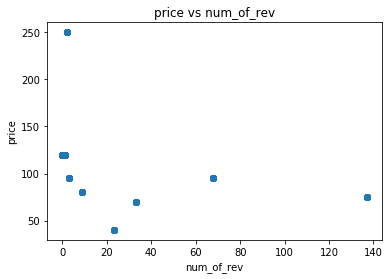

In [44]:
plt.scatter(dfg.number_of_reviews,df1.price)
plt.xlabel('num_of_rev')
plt.ylabel('price')
plt.title('price vs num_of_rev')

Text(0.5, 1.0, 'hist of num_of_rev')

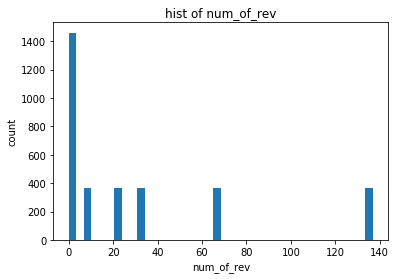

In [45]:
plt.hist(dfg.number_of_reviews, bins=40)
plt.xlabel('num_of_rev')
plt.ylabel('count')
plt.title('hist of num_of_rev')

Text(0.5, 1.0, 'price vs rev_sco_rate')

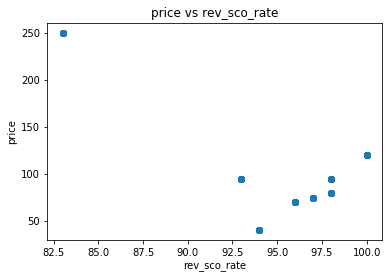

In [46]:
plt.scatter(dfg.review_scores_rating,df1.price)
plt.xlabel('rev_sco_rate')
plt.ylabel('price')
plt.title('price vs rev_sco_rate')

C:\Users\aimaz\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\aimaz\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'price vs rev_sco_rate')

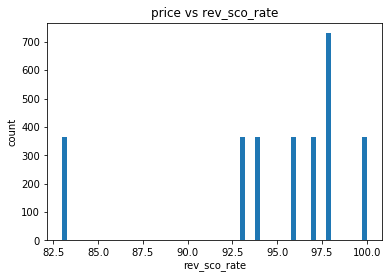

In [47]:
plt.hist(dfg.review_scores_rating,bins=60)
plt.xlabel('rev_sco_rate')
plt.ylabel('count')
plt.title('price vs rev_sco_rate')

to answer **4.)** how review counts/score correlate to price we found that conter to conventional wisdom higher and relatively higher prices were given to those with few or no reviews, and there tends more of these places.
also generally there seems to be a willingness to go with place with highest price but lowest rating of 83. Possbly due to high demand? we can even draw parallels and find that the group with the highest price of $250.00 adds upp to a couple of percent more than 10%.

## Conclusion

**So, great!** we answered everything! found the features that go into an possible Airbnb pricing model, we built said model 
and figured out how to maximize this for the platform. Also found out how the demand picture for Seattle on Airbnb.  

--------------<:)----------------